In [ ]:
import numpy as np
from scipy.integrate import odeint, ode
import matplotlib.pyplot as plt
import json
from dataclasses import dataclass
from typing import Tuple

In [ ]:
compartments = json.load(open('compartments.json'))
flows = json.load(open('flows.json'))
metadata = json.load(open('metadata.json'))
flowscoefs, initial_conditions, susceptibility, contagiousness = \
  (lambda obj: (obj["flows"], obj["initial_conditions"], obj["susceptibility"], obj["contagiousness"]))(json.load(open('parameters.json')))

In [ ]:
shape = tuple(int(dim['size']) for dim in metadata)

In [ ]:
coefsArray = [v for k,v in flowscoefs.items()]
susceptibility = [v for k,v in susceptibility.items()]
contagiousness = [v for k,v in contagiousness.items()]

In [ ]:
flowsbycompartment = [([], []) for compartment in compartments] # each compartment has an in and an out list

In [ ]:
@dataclass
class Delta:
  batches: list
  rates: list
  contacts: list

@dataclass
class Batch:
  coef_indices: Tuple[int, int]

@dataclass
class Rate:
  coef_indices: Tuple[int, int]
  from_index: int

@dataclass
class Contact:
  coef_indices: Tuple[int, int]
  from_index: int
  contact_index: int

types = [Batch, Rate, Contact]

In [ ]:
for dim_index in range(len(shape)):
  for flowsOfDim in flows[dim_index]:
    flowid = flowsOfDim['id']
    coefs_index = next(i for i, (k, v) in enumerate(flowscoefs.items()) if k == flowid)
    for flow_index, flow in enumerate(flowsOfDim['flows']):
      to_i = compartments.index(flow['to'])
      from_i = compartments.index(flow['from'])
      term = None
      if flow['type'] == 'Batch':
        term = Batch((coefs_index, flow_index))
      elif flow['type'] == 'Rate':
        term = Rate((coefs_index, flow_index), from_i)
      elif flow['type'] == 'Contact':
        contact_i = compartments.index(flow['contact'])
        term = Contact((coefs_index, flow_index), from_i, contact_i)
      else:
        raise 1
      flowsbycompartment[to_i][0].append(term)
      flowsbycompartment[from_i][1].append(term)

In [ ]:
flowsbycompartment = [[Delta(*[[f for f in flows if isinstance(f, T)] for T in types]) for flows in compartmentflows] for compartmentflows in flowsbycompartment]

In [ ]:
def getCoefForFlow(flow):
  return coefsArray[flow.coef_indices[0]][flow.coef_indices[1]]

In [ ]:
def evalDelta(delta, state):
  b = sum([getCoefForFlow(batch) for batch in delta.batches])
  r = sum([getCoefForFlow(rate) * state[rate.from_index] for rate in delta.rates])
  m = sum([getCoefForFlow(contact) *
           state[contact.from_index] * susceptibility[contact.from_index] *
           state[contact.contact_index] * contagiousness[contact.contact_index]
             for contact in delta.contacts])
  return b + r + m

In [ ]:
def derivativeFor(compartment):
  i = compartments.index(compartment)
  def derivativeForThis(x):
    inflows = evalDelta(flowsbycompartment[i][0], x)
    outflows = evalDelta(flowsbycompartment[i][1], x)
    return inflows - outflows
  return derivativeForThis

In [ ]:
derivatives = [derivativeFor(c) for c in compartments]

In [ ]:
for i, compartment in enumerate(compartments):
  n = initial_conditions[compartment]
  s = susceptibility[i]
  c = contagiousness[i]
  if len(compartment) < 32:
    compartment += "\t"
  print(f"{compartment}\tN={n}\tSusceptibility={s}\tContagiousness={c}")

[S, 0]		N=0.9	Susceptibility=1	Contagiousness=1
[S, 1]		N=0.9	Susceptibility=1	Contagiousness=1
[E, 0]		N=0.1	Susceptibility=1	Contagiousness=1
[E, 1]		N=0.1	Susceptibility=1	Contagiousness=1
[I, 0]		N=0	Susceptibility=1	Contagiousness=1
[I, 1]		N=0	Susceptibility=1	Contagiousness=1
[R, 0]		N=0	Susceptibility=1	Contagiousness=1
[R, 1]		N=0	Susceptibility=1	Contagiousness=1


In [ ]:
def model_derivative(state, t):
  state = [x if x > 0 else 0 for x in state]
  d = [derivatives[i](state) for i in range(len(state))]
  return d

min, max = 0, 100
steps = 1000
t_span = np.linspace(min, max, num=steps)

solution = odeint(model_derivative, [initial_conditions[c] for c in compartments], t_span)

In [ ]:
solution[:4]

array([[9.00000000e-01, 9.00000000e-01, 1.00000000e-01, 1.00000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.99964408e-01, 8.99964408e-01, 9.80532565e-02, 9.80532565e-02,
        1.96256165e-03, 1.96256165e-03, 1.97735916e-05, 1.97735916e-05],
       [8.99859472e-01, 8.99859472e-01, 9.62137644e-02, 9.62137644e-02,
        3.84868614e-03, 3.84868614e-03, 7.80772211e-05, 7.80772211e-05],
       [8.99687937e-01, 8.99687937e-01, 9.44766540e-02, 9.44766540e-02,
        5.66201026e-03, 5.66201026e-03, 1.73398478e-04, 1.73398478e-04]])

In [ ]:
# This was to test to avoid having negative values in X
# imagine a vaccination batch kept on too long and you end up with negative unvaccinated people
# it works by controlling X during the ode solving process with a loop so you can add you condition such as `len([y for y in r.y if y < 0]) == 0`




# def model_derivative(t, state):
#   state = [x if x > 0 else 0 for x in state]
#   d = [derivatives[i](state) for i in range(len(state))]
#   return d

# r = ode(model_derivative)
# r.set_initial_value([initial_conditions[str(c['id']).replace("'", "")] for c in compartments], 0)
# dt = 0.01
# while r.successful() and len([y for y in r.y if y < 0]) == 0:
#   for e in list(zip([c['id'] for c in compartments], r.integrate(r.t + dt))):
#     print(e)
#   break

In [ ]:
def plotdim(dim):
  plt.figure(figsize=(10, 10))
  swapped = list(range(len(shape)))
  swapped[0], swapped[dim] = dim, 0
  labels = metadata[dim]['labels']
  compartmentsToPlotArray = np.array(compartments).reshape(shape).transpose(swapped)
  for label, compartmentsToPlot in zip(labels, compartmentsToPlotArray):
    plt.plot(t_span, [sum(x) for x in solution[:, [compartments.index(id) for id in compartmentsToPlot]]], label=label)
  plt.title(metadata[dim]['id'])
  plt.legend();
  plt.xlabel('time');

In [ ]:
def plotsingleflowfromdim(dim, flow):
  plt.figure(figsize=(10, 10))
  swapped = list(range(len(shape)))
  swapped[0], swapped[dim] = dim, 0
  labels = metadata[dim]['labels']
  compartmentsToPlotArray = np.array(compartments).reshape(shape).transpose(swapped)
  for label, compartmentsToPlot in zip(labels, compartmentsToPlotArray):
    if label == flow:
      plt.plot(t_span, [sum(x) for x in solution[:, [compartments.index(id) for id in compartmentsToPlot]]], label=label)
  plt.title(f'{metadata[dim]["id"]}: {flow}')
  plt.legend();
  plt.xlabel('time');

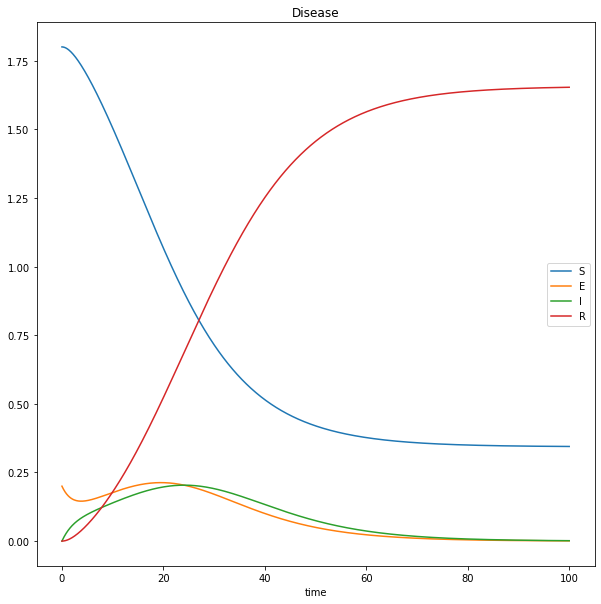

In [ ]:
plotdim(0) # Changed initial values to 0.9,0.1,0.0 to make a more appealing graph

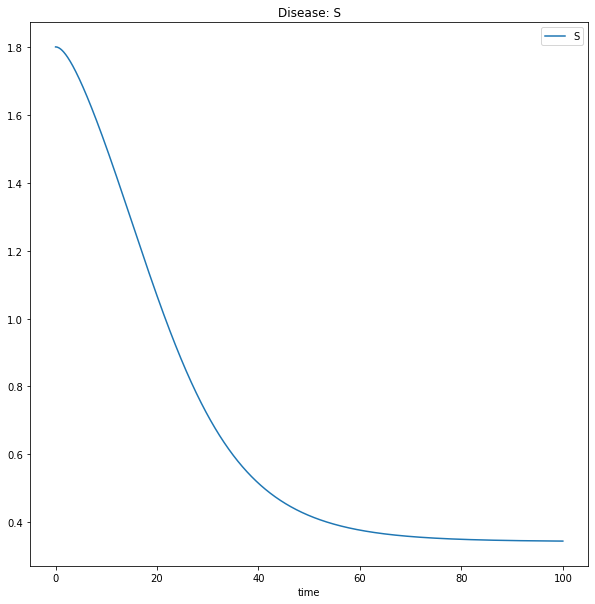

In [ ]:
plotsingleflowfromdim(0, 'S')

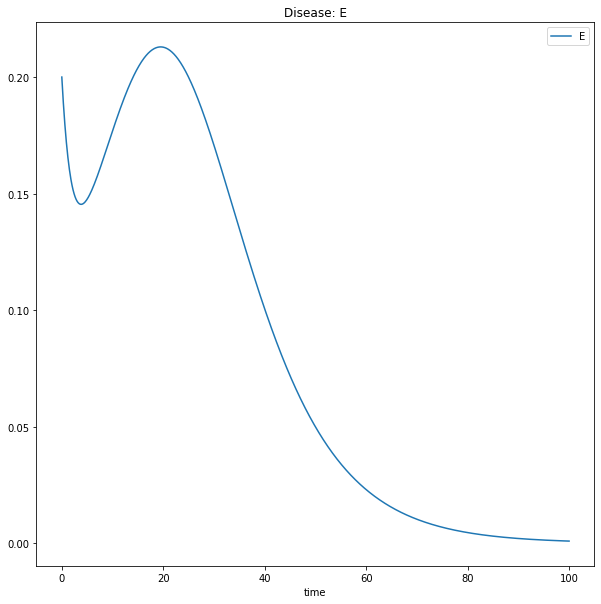

In [ ]:
plotsingleflowfromdim(0, 'E')

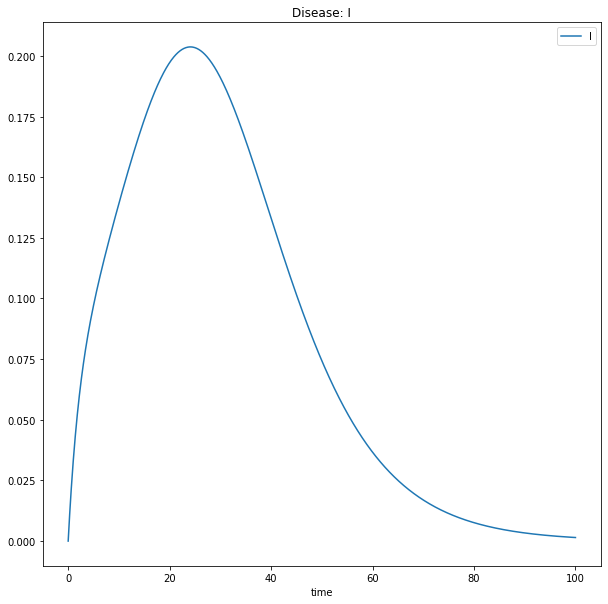

In [ ]:
plotsingleflowfromdim(0, 'I')

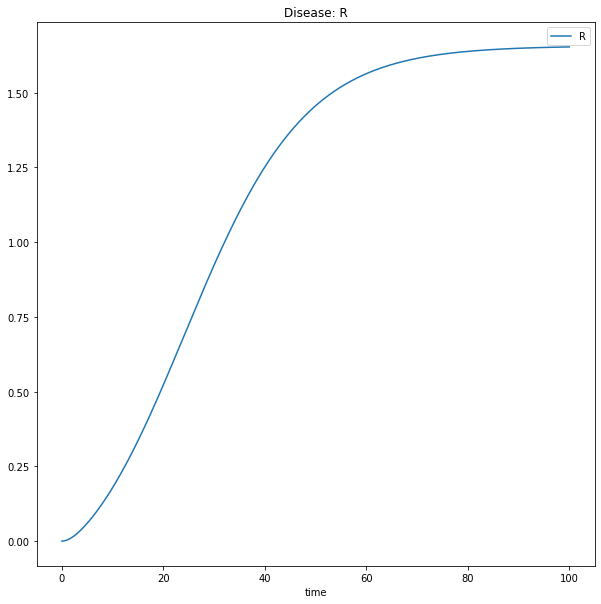

In [ ]:
plotsingleflowfromdim(0, 'R')